In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import yahoo_fin.stock_info as si

import talib
from mplfinance.original_flavor import candlestick_ohlc

from matplotlib.pylab import date2num

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [2]:
import sys
sys.version
path = sys.path[0] + '/'
path

'/Users/maitreyasinha/IIT-B Course/Data Mining/Portfolio-Analysis/'

In [3]:
training_window = 60
prediction_window = 12

cols = ['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker']
cols_to_drop = ["Date", "adjclose", "ticker"]
cols_to_keep = [i for i in cols if i not in cols_to_drop]
cols_to_keep

['open', 'high', 'low', 'close', 'volume']

In [4]:
def get_indicators(data):
    # Get MACD
    data["macd"], data["macd_signal"], data["macd_hist"] = talib.MACD(data['close'])
    
    # Get MA10 and MA30
    data["ma10"] = talib.MA(data["close"], timeperiod=10)
    data["ma30"] = talib.MA(data["close"], timeperiod=30)
    
    # Get RSI
    data["rsi"] = talib.RSI(data["close"])
    
    #Get the Average True Range
    data['ATR'] = talib.ATR(data['high'], data['low'], data['close'])
    
    # Compute the logarithmic returns using the Closing price 
    data['Log_Ret'] = np.log(data['close'] / data['close'].shift(21))

    # Compute Volatility using the pandas rolling standard deviation function
    data['volatility'] = data['Log_Ret'].rolling(window=21 ).std() * np.sqrt(21)
    
    #Compute the Sharpe Ratio 
    df["Sharpe Ratio"] = df["Log_Ret"]/df["volatility"]
    
    return data.dropna()

In [5]:
def plot_chart(data, n, ticker, save=False):
    
    # Filter number of observations to plot
    data = data.iloc[-n:]
    
    # Create figure and set axes for subplots
    fig = plt.figure()
    fig.set_size_inches((20, 16))
    ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
    ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
    ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
    ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
    # Format x-axis ticks as dates
    ax_candle.xaxis_date()
    
    # Get nested list of date, open, high, low and close prices
    ohlc = []
    for date, row in data.iterrows():
        openp, highp, lowp, closep = row[:4]
        ohlc.append([date2num(date), openp, highp, lowp, closep])
 
    # Plot candlestick chart
    ax_candle.plot(data.index , data["close"], label="Closing" ,linewidth=2,)
    ax_candle.plot(data.index, data["ma10"], label="MA10")
    ax_candle.plot(data.index, data["ma30"], label="MA30")
    candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
    ax_candle.legend()
    
    # Plot MACD
    ax_macd.set_ylabel("MACD")
    ax_macd.plot(data.index, data["macd"], label="macd")
    ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
    ax_macd.plot(data.index, data["macd_signal"], label="signal")
    ax_macd.legend()
    
    # Plot RSI
    # Above 70% = overbought, below 30% = oversold
    ax_rsi.set_ylabel(" RSI (%)")
    ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
    ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
    ax_rsi.plot(data.index, data["rsi"], label="rsi")
    ax_rsi.legend()
    
    # Plot ATR --> Volatility
    ax_vol.set_ylabel("Volatility")
    ax_vol.plot(data.index, data["ATR"], label="Average True Range")
    ax_vol.legend()
    
    # Save the chart as PNG
    if save:
        fig.savefig(path + ticker + ".jpeg", bbox_inches="tight", dpi=300)
    
    plt.show()

In [6]:
#2005-07-28
stocks = {"YESBANK.NS" : 0.2, "TATAMOTORS.NS":0.2, "HDFCBANK.NS":0.2, "RELIANCE.NS":0.2,"BAJAJ-AUTO.NS":0.2}
stocks_df = {}
df = None
# indices = set([])

for stock in stocks.keys():
    print("pulling data for ", stock)
    _df = si.get_data(stock)
    _df.dropna(inplace=True)
    stocks_df[stock] = _df
    if df is None:
        df = _df[cols_to_keep]*stocks.get(stock)
        indices = set(df.index.astype('str').tolist())
    else:
        indices = indices.intersection(set(_df.index.astype('str').tolist()))
        df = df.loc[indices]
        _df = _df.loc[indices]
        df[cols_to_keep] += _df[cols_to_keep]*stocks.get(stock)

df.head()

pulling data for  YESBANK.NS
pulling data for  TATAMOTORS.NS
pulling data for  HDFCBANK.NS
pulling data for  RELIANCE.NS
pulling data for  BAJAJ-AUTO.NS


,open,high,low,close,volume
2018-09-19,1115.794998,1127.339990,1104.659998,1110.665021,8796136.4
2014-08-19,735.874803,754.354802,732.785997,748.793785,9928847.6
2019-11-11,1233.770004,1242.650000,1226.450011,1234.980029,59750963.4
2020-09-24,1270.339961,1283.349981,1249.750020,1255.840015,39684551.8
2015-07-03,844.372006,852.977002,841.288007,847.229001,3566531.0


In [7]:
df.index.min(), df.index.max()
_df.columns

Index(['open', 'high', 'low', 'close', 'adjclose', 'volume', 'ticker'], dtype='object')

In [8]:
df.dropna(inplace=True)
df = df.reset_index()
df.rename(columns = {'index':'Date'}, inplace = True)
# df.drop(["volume"],axis=1,inplace=True)
df.head()

,Date,open,high,low,close,volume
0,2018-09-19,1115.794998,1127.339990,1104.659998,1110.665021,8796136.4
1,2014-08-19,735.874803,754.354802,732.785997,748.793785,9928847.6
2,2019-11-11,1233.770004,1242.650000,1226.450011,1234.980029,59750963.4
3,2020-09-24,1270.339961,1283.349981,1249.750020,1255.840015,39684551.8
4,2015-07-03,844.372006,852.977002,841.288007,847.229001,3566531.0


In [9]:
df["Date"].min(), df["Date"].max()

(Timestamp('2012-06-18 00:00:00'), Timestamp('2020-12-14 00:00:00'))

In [10]:
mdf = df[:100]
mdf.head()
print(len(mdf))
mdf.sort_values('Date')

100


,Date,open,high,low,close,volume
23,2012-06-25,498.002805,502.952397,494.283994,497.251408,5442112.8
58,2012-07-04,506.872601,512.143002,502.558000,508.589589,6017660.8
89,2012-07-17,489.187798,490.422797,474.443987,477.990608,5544065.4
12,2012-07-24,496.233398,503.245808,494.734193,498.048801,4536760.4
6,2012-08-01,509.703400,519.931398,508.316194,515.962404,5715046.8
...,...,...,...,...,...,...
77,2020-09-15,1300.319970,1305.250004,1285.659986,1297.930038,29573628.8
85,2020-09-21,1312.539990,1323.019985,1279.590039,1288.570019,36742844.6
3,2020-09-24,1270.339961,1283.349981,1249.750020,1255.840015,39684551.8
63,2020-10-23,1305.419999,1326.229989,1294.299952,1316.280020,32361153.0


['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio'] ['open', 'high', 'low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'ma10', 'ma30', 'rsi', 'ATR', 'Log_Ret', 'volatility', 'Sharpe Ratio']


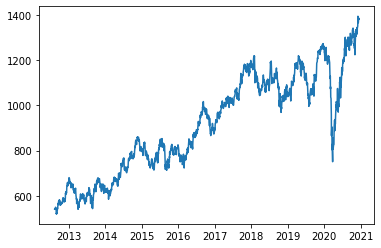

In [11]:
if "Date" in df.columns:
    df.sort_values("Date", inplace=True)
    df= df.set_index("Date")
#     df.index = df.index.sort_values()
    split_date = '2020-01-01'

    df = get_indicators(df)
    df.dropna(inplace=True)
    df_data_training = df[df.index < split_date]
    df_data_test = df[df.index >= split_date]
    
plt.plot(df.index,df["open"])

print(df.columns.to_list() , df_data_training.columns.to_list())
# df.head()

In [12]:
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2012-08-14,541.626201,545.095401,532.980209,539.619196,5734537.8,10.534838,7.248650,3.286188,529.521201,508.862286,71.267839,11.772167,0.102695,0.180559,0.568764
2012-08-16,542.892198,546.417198,536.624194,541.160202,6781406.4,10.844568,7.967833,2.876735,532.040981,509.947973,72.028196,11.630798,0.124124,0.190531,0.651467
2012-08-17,541.727600,546.718613,537.252995,542.304201,5899721.6,11.054909,8.585248,2.469660,534.687561,511.182627,72.607735,11.476143,0.096626,0.193606,0.499086
2012-08-21,543.826199,549.113208,541.598199,546.582399,5638764.4,11.435005,9.155200,2.279805,537.987000,512.684034,74.717359,11.193204,0.089163,0.195142,0.456916
2012-08-22,544.822794,552.982591,543.597188,548.783405,4910942.2,11.778066,9.679773,2.098293,540.278162,514.504021,75.752019,11.064076,0.078584,0.195786,0.401376


In [13]:
df.index = df.index.sort_values()
df.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2012-08-14,541.626201,545.095401,532.980209,539.619196,5734537.8,10.534838,7.248650,3.286188,529.521201,508.862286,71.267839,11.772167,0.102695,0.180559,0.568764
2012-08-16,542.892198,546.417198,536.624194,541.160202,6781406.4,10.844568,7.967833,2.876735,532.040981,509.947973,72.028196,11.630798,0.124124,0.190531,0.651467
2012-08-17,541.727600,546.718613,537.252995,542.304201,5899721.6,11.054909,8.585248,2.469660,534.687561,511.182627,72.607735,11.476143,0.096626,0.193606,0.499086
2012-08-21,543.826199,549.113208,541.598199,546.582399,5638764.4,11.435005,9.155200,2.279805,537.987000,512.684034,74.717359,11.193204,0.089163,0.195142,0.456916
2012-08-22,544.822794,552.982591,543.597188,548.783405,4910942.2,11.778066,9.679773,2.098293,540.278162,514.504021,75.752019,11.064076,0.078584,0.195786,0.401376


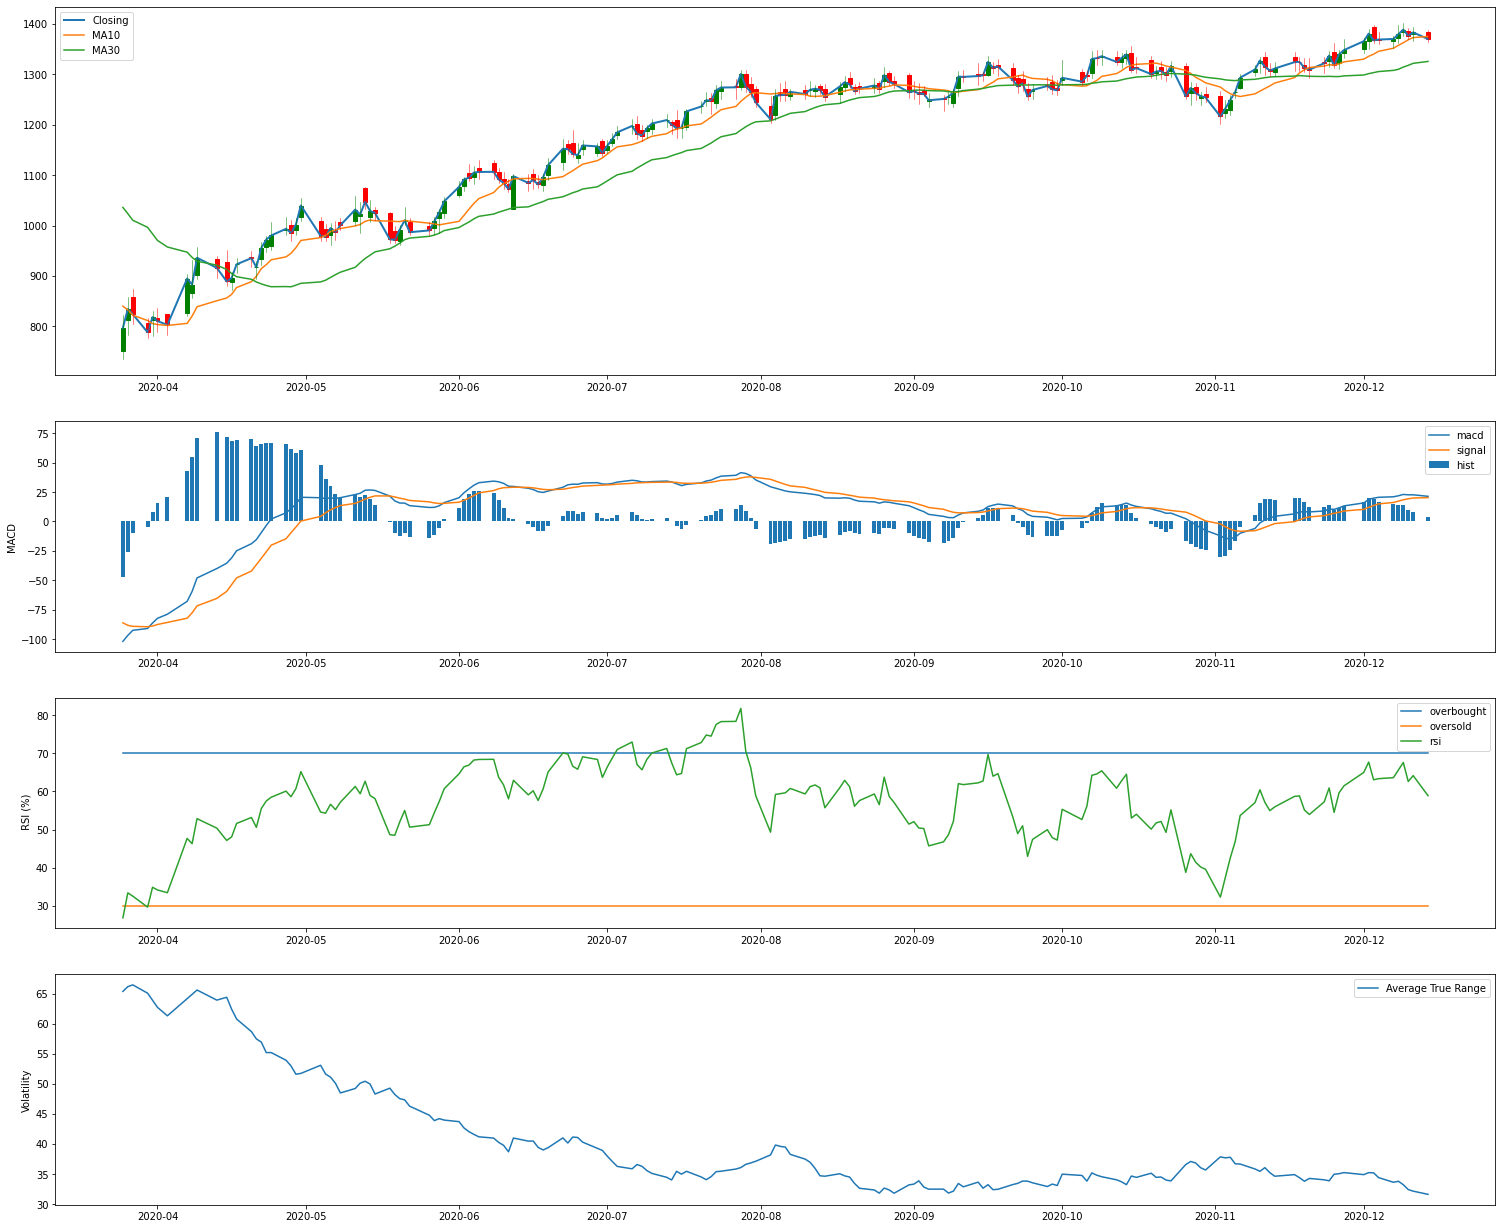

In [14]:
# _df = df.set_index("Date")
plot_chart(df, 180, 'Custom')

Training Size : 1810, Test Size : 238


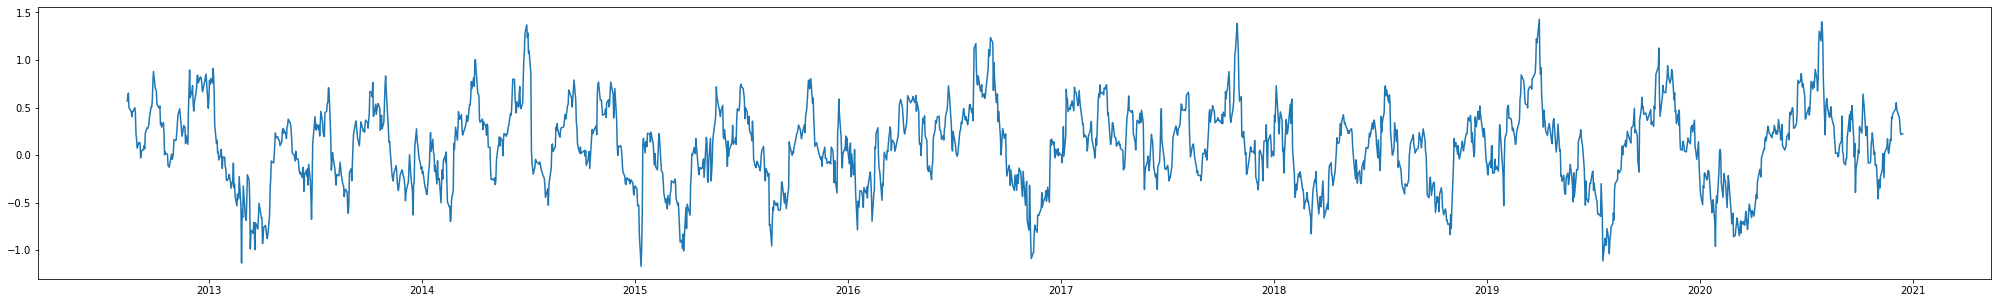

In [15]:
print("Training Size : {}, Test Size : {}".format(len(df_data_training), len(df_data_test)) )
df.head()
plt.figure(figsize=(35,5))
plt.plot(df.index, df["Sharpe Ratio"])

In [16]:
data_training = df_data_training.copy()
data_training.dropna(inplace=True)

## Scaler

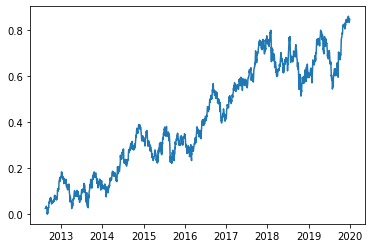

In [17]:
scaler = MinMaxScaler()
scaler.fit(df)

training_Dataset = scaler.transform(data_training)
_scale = 1/scaler.scale_[0]
plt.plot(data_training.index, training_Dataset[:,0])

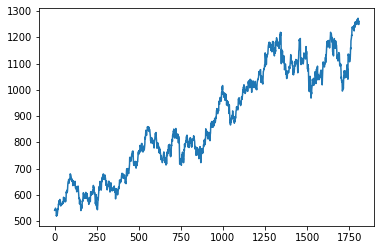

In [18]:
_df = scaler.inverse_transform(training_Dataset)
plt.plot(_df[:,0])
# _df

1810 2048


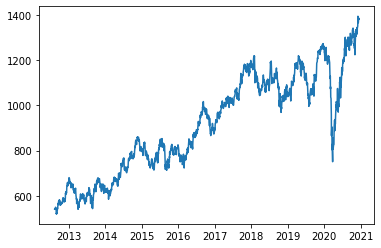

In [19]:
print(len(data_training), len(df))
plt.plot(df.index,df["open"])

## Training Pipeline

In [20]:
X_train = []
y_train = []
for i in range(training_window, training_Dataset.shape[0]-prediction_window):
    X_train.append(training_Dataset[i-training_window:i])
    y_train.append(training_Dataset[i+prediction_window,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
print("Shape of X is : {}, Shape of Y is : {}".format(X_train.shape,y_train.shape))

Shape of X is : (1738, 60, 15), Shape of Y is : (1738,)


In [22]:
print("Shape of data_training.index", data_training.index[training_window:].shape)

Shape of data_training.index (1750,)


In [23]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        if logs["loss"] < 0.0030:
            print("\nFinal Loss : {}".format(logs["loss"]))
            self.model.stop_training = True

In [24]:
model = Sequential([
    LSTM(units=120, activation='relu', return_sequences = True, input_shape = (60,15)),
    Dropout(0.4),
    LSTM(units=90, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=80, activation='relu', return_sequences = True),
    Dropout(0.3),
    LSTM(units=70, activation='relu'),
    Dropout(0.3),
    Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 120)           65280     
_________________________________________________________________
dropout (Dropout)            (None, 60, 120)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 90)            75960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 90)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 80)            54720     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 70)                4

In [25]:
model_name = path + "daily_predictor.hdf5"
# model.load_weights(model_name)

In [26]:
model.compile(optimizer= tf.optimizers.RMSprop() , loss= tf.losses.MeanSquaredError())
X_train.shape, y_train.shape
model.fit(X_train,y_train, epochs=30, callbacks = CustomCallback())

Epoch 1/30
55/55 [==============================] - 5s 98ms/step - loss: 0.0513
Epoch 2/30
55/55 [==============================] - 5s 88ms/step - loss: 0.0150
Epoch 3/30
55/55 [==============================] - 5s 87ms/step - loss: 0.0124
Epoch 4/30
55/55 [==============================] - 5s 85ms/step - loss: 0.0105
Epoch 5/30
55/55 [==============================] - 5s 89ms/step - loss: 0.0095
Epoch 6/30
55/55 [==============================] - 6s 109ms/step - loss: 0.0080
Epoch 7/30
55/55 [==============================] - 5s 98ms/step - loss: 0.0077
Epoch 8/30
55/55 [==============================] - 5s 90ms/step - loss: 0.0070
Epoch 9/30
55/55 [==============================] - 5s 86ms/step - loss: 0.0066
Epoch 10/30
55/55 [==============================] - 5s 89ms/step - loss: 0.0058
Epoch 11/30
55/55 [==============================] - 5s 88ms/step - loss: 0.0060
Epoch 12/30
55/55 [==============================] - 5s 92ms/step - loss: 0.0059
Epoch 13/30
55/55 [=================

In [27]:
# model.save(model_name)
# scaler.data_min_[0]

In [28]:
test_pred = model.predict(X_train)
model.evaluate(X_train, y_train)
test_pred
test_pred = test_pred * _scale + scaler.data_min_[0]
y_train = y_train * _scale + scaler.data_min_[0]

# test_pred.shape

55/55 [==============================] - 2s 42ms/step - loss: 0.0034


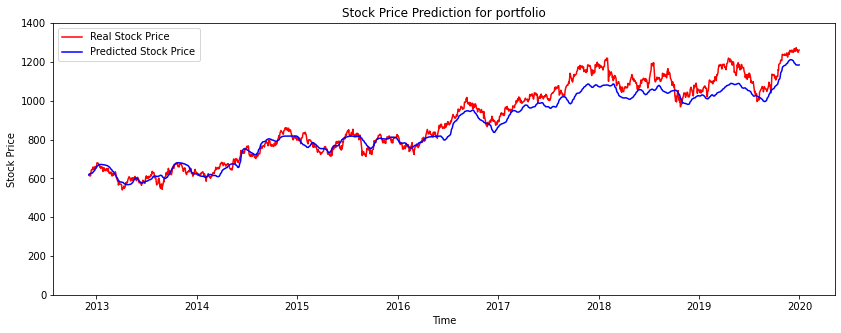

In [29]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(data_training.index[training_window+prediction_window:], y_train, color = 'red', label = 'Real Stock Price')
plt.plot(data_training.index[training_window+prediction_window:], test_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for portfolio')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
plt.ylim(0,y_train.max()*1.1)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/training_output.jpeg", dpi=300)
plt.show()

In [30]:
past_60_days = df_data_training.tail(training_window)
df_data_test.head(4)

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2020-01-01,1241.839994,1247.009995,1229.660016,1233.880009,27363888.0,3.000705,7.269832,-4.269127,1255.782993,1253.348995,42.493767,20.573217,-0.010834,0.046425,-0.233357
2020-01-02,1235.549990,1248.929990,1226.810011,1236.830009,38230051.6,1.576842,6.131234,-4.554392,1253.397997,1253.132329,44.208076,20.683700,-0.020423,0.054829,-0.372495
2020-01-03,1236.189989,1239.760004,1217.539995,1223.160020,31569180.8,-0.647173,4.775553,-5.422725,1248.790001,1252.319663,38.483083,20.793436,-0.027752,0.064332,-0.431380
2020-01-06,1217.550000,1219.810034,1198.420010,1202.179970,29702324.6,-4.055882,3.009266,-7.065148,1242.469999,1251.120661,31.698347,21.075334,-0.041843,0.080100,-0.522384


In [31]:

df_test = past_60_days.append(df_data_test).sort_index()
df_test.dropna(inplace=True)
df_test.head()

,open,high,low,close,volume,macd,macd_signal,macd_hist,ma10,ma30,rsi,ATR,Log_Ret,volatility,Sharpe Ratio
Date,,,,,,,,,,,,,,,
2019-10-01,1134.700000,1147.769990,1108.890015,1122.200015,173463121.4,19.226641,14.566661,4.659980,1113.142601,1081.084265,59.522002,30.967373,0.059909,0.137186,0.436702
2019-10-03,1117.759991,1133.029990,1105.600005,1119.480000,132846895.4,18.381696,15.329668,3.052028,1119.841001,1082.940398,58.512182,30.714703,0.049426,0.135591,0.364522
2019-10-04,1127.870010,1134.579991,1100.780006,1104.629996,112950881.2,16.325609,15.528856,0.796752,1126.358997,1084.266398,53.205056,30.935080,0.051202,0.135743,0.377201
2019-10-07,1107.079966,1121.610015,1099.389985,1110.490010,81378225.8,14.996132,15.422311,-0.426179,1125.968999,1085.772865,54.941831,30.312576,0.059889,0.136245,0.439570
2019-10-09,1111.749986,1128.399995,1103.349999,1121.780025,81061969.6,14.684252,15.274700,-0.590448,1124.648005,1088.218532,58.163495,29.936678,0.065104,0.136227,0.477910


In [32]:
inputs = scaler.transform(df_test)
inputs

array([[0.70321368, 0.71128531, 0.6970273 , ..., 0.69894709, 0.10622424,
        0.61890616],
       [0.68382993, 0.6944519 , 0.69327873, ..., 0.68554297, 0.10454037,
        0.591127  ],
       [0.69539841, 0.69622204, 0.68778691, ..., 0.68781445, 0.10470095,
        0.59600671],
       ...,
       [0.99042255, 0.98880817, 0.99324347, ..., 0.68608644, 0.16885752,
        0.54846122],
       [0.98329387, 0.99302222, 0.98968861, ..., 0.67507565, 0.16387513,
        0.53358415],
       [0.98824844, 0.98529076, 0.98645275, ..., 0.67440745, 0.15367614,
        0.53686959]])

In [33]:
X_test = []
y_test = []

for i in range(training_window, inputs.shape[0]-prediction_window):
    X_test.append(inputs[i-training_window:i])
    y_test.append(inputs[i+prediction_window, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((226, 60, 15), (226,))

In [34]:
y_pred = model.predict(X_test)
y_pred.shape

(226, 1)

In [35]:
scaler.scale_

array([1.14425851e-03, 1.14202237e-03, 1.13938065e-03, 1.15028178e-03,
       4.28766698e-09, 6.91456532e-03, 7.84613655e-03, 2.08577301e-02,
       1.18106666e-03, 1.22477018e-03, 1.37189709e-02, 1.79745613e-02,
       1.27858088e+00, 1.05551433e+00, 3.84859846e-01])

In [36]:
y_pred = y_pred* _scale + scaler.data_min_[0]
y_test = y_test* _scale + scaler.data_min_[0]
y_pred.shape

(226, 1)

In [37]:
model.evaluate(X_test,  y_test)

8/8 [==============================] - 0s 34ms/step - loss: 1390075.7500


1390075.75

In [38]:
y_test.max()

1394.069990158081

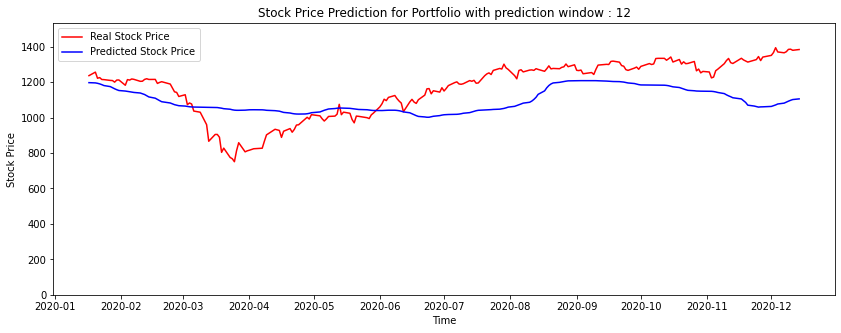

In [39]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(df_test.index[training_window+prediction_window:], y_test, color = 'red', label = 'Real Stock Price')
plt.plot(df_test.index[training_window+prediction_window:], y_pred, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction for Portfolio with prediction window : '+ str(prediction_window))
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
# plt.xlim(0,900)
y_test
plt.ylim(0,y_test.max()*1.1)
# plt.savefig("/Users/maitreyasinha/IIT-B Course/Data Mining/StockPricePrediction/Algorithmic-trading/test_output.jpeg", dpi=300)
plt.show()

## Portfolio Analysis and Co-relation

In [84]:
stocks_df
stock = list(stocks_df.keys())
num_stocks = len(stock)
num_stocks

5

In [85]:
df = None
for st in stocks_df.keys():
    if df is None:
        df = stocks_df[st].copy()
        df[st] = (_df["open"] + _df["close"])/2
        df = pd.DataFrame(df[st])
    else:
        _df = stocks_df[st]
        df[st] = (_df["open"] + _df["close"])/2
        
df.dropna(inplace=True)        
df.head()

,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS
2012-06-18,1540.974976,237.923004,271.737503,362.312500,1540.974976
2012-06-19,1537.700012,236.043503,267.812500,363.612503,1537.700012
2012-06-20,1535.099976,240.890999,267.800003,368.850006,1535.099976
2012-06-21,1534.025024,243.958496,268.975006,363.175003,1534.025024
2012-06-22,1534.700012,243.364998,269.862488,356.137497,1534.700012


In [86]:
stock_ret = df.pct_change()*100

mean_returns = stock_ret.mean()
cov_matrix = stock_ret.cov()


In [109]:
#Set the number of iterations to 10000 and define an array to hold the simulation results; initially set to all zeros
num_iterations = 10000
simulation_res = np.zeros((4+num_stocks-1,num_iterations))

In [110]:
for i in range(num_iterations):
#Select random weights and normalize to set the sum to 1
    weights = np.array(np.random.random(5))
    weights /= np.sum(weights)
#Calculate the return and standard deviation for every step
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
#Store all the results in a defined array
    simulation_res[0,i] = portfolio_return
    simulation_res[1,i] = portfolio_std_dev
#Calculate Sharpe ratio and store it in the array
    simulation_res[2,i] = simulation_res[0,i] / simulation_res[1,i]
#Save the weights in the array
    for j in range(len(weights)):
        simulation_res[j+3,i] = weights[j]

In [111]:
sim_frame = pd.DataFrame(simulation_res.T,columns=['ret','stdev','sharpe']+stock)
sim_frame.head()

,ret,stdev,sharpe,YESBANK.NS,TATAMOTORS.NS,HDFCBANK.NS,RELIANCE.NS,BAJAJ-AUTO.NS
0,0.050562,1.099444,0.045989,0.255976,0.249106,0.268503,0.093702,0.132713
1,0.052556,1.159523,0.045325,0.004849,0.318732,0.224347,0.226012,0.226060
2,0.055080,1.094835,0.050309,0.127536,0.232490,0.156580,0.272044,0.211350
3,0.062214,1.002962,0.062031,0.227619,0.085940,0.401334,0.103824,0.181283
4,0.055414,1.055226,0.052514,0.286009,0.037115,0.150539,0.136834,0.389502


In [112]:
#Spot the position of the portfolio with highest Sharpe Ratio
max_sharpe = sim_frame.iloc[sim_frame['sharpe'].idxmax()]

In [113]:
#Spot the position of the portfolio with minimum Standard Deviation
min_std = sim_frame.iloc[sim_frame['stdev'].idxmin()]
print("The portfolio for max Sharpe Ratio:\n", max_sharpe)
print("The portfolio for min risk:\n", min_std)

The portfolio for max Sharpe Ratio:
 ret              0.076675
stdev            1.006771
sharpe           0.076160
YESBANK.NS       0.117671
TATAMOTORS.NS    0.038879
HDFCBANK.NS      0.466272
RELIANCE.NS      0.318796
BAJAJ-AUTO.NS    0.058382
Name: 899, dtype: float64
The portfolio for min risk:
 ret              0.069160
stdev            0.981811
sharpe           0.070441
YESBANK.NS       0.214093
TATAMOTORS.NS    0.010449
HDFCBANK.NS      0.346626
RELIANCE.NS      0.240345
BAJAJ-AUTO.NS    0.188486
Name: 618, dtype: float64


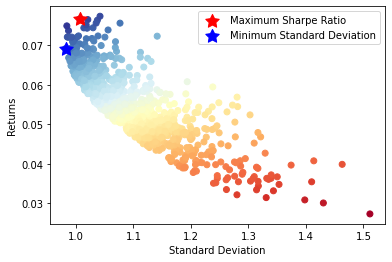

In [123]:
#Create a scatter plot coloured by various Sharpe Ratios with standard deviation on the x-axis and returns on the y-axis
plt.scatter(sim_frame.stdev,sim_frame.ret,c=sim_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.scatter(max_sharpe[1],max_sharpe[0],marker=(5,1,0),color='r',s=200, label="Maximum Sharpe Ratio")
plt.scatter(min_std[1],min_std[0],marker=(5,1,0),color='b',s=200, label="Minimum Standard Deviation")
plt.legend()

In [151]:
max_sharpe = simulation_res[2,:].max()

for it in range(num_iterations):
    if simulation_res[2,it] == max_sharpe:
        print(it)
        break
print(simulation_res[:,it])

print("Optimum Allocation")
list(zip(stock,simulation_res[:,it][-num_stocks:]))

899
[0.07667547 1.00677141 0.07615976 0.11767129 0.03887864 0.46627207
 0.31879649 0.05838151]
Optimum Allocation


[('YESBANK.NS', 0.11767128995662883),
 ('TATAMOTORS.NS', 0.03887864251462101),
 ('HDFCBANK.NS', 0.46627206857678266),
 ('RELIANCE.NS', 0.31879649048285164),
 ('BAJAJ-AUTO.NS', 0.05838150846911571)]

In [153]:
simulation_res[:,it][-num_stocks:].sum()

0.9999999999999999